In [4]:
import tensorflow as tf
from dec_model import DECModel, dec_loss, train_dec_model  # Ensure that the DECModel class is available in the notebook's environment

In [5]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

def load_and_preprocess_data():

    np.random.seed(42)
    idx = pd.IndexSlice

    meta = pd.read_hdf('/home/groovyjac/projects/autonomous-portfolio-management/main_data_store_JDKv1.h5',
                        'stocks/base_fundamentals')

    selected_features = ['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'RevenueTTM',
             'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'PriceSalesTTM',
       'PriceBookMRQ', 'EnterpriseValue', 'EnterpriseValueRevenue',
       'EnterpriseValueEbitda', 'PercentInstitutions','PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA',
       'ForwardPE', 'SharesFloat', 'PercentInsiders', 'ShortPercent',
       'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 'TrailingPE',
       'DividendShare',]
   

    df = pd.DataFrame(meta.loc[idx[:, :, selected_features]])
    df = df.droplevel(1)[~df.droplevel(1).index.duplicated(keep='first')]
    df = df.unstack(level=1)
    df.columns = df.columns.droplevel(0)
    df = df.astype('float64')
    
    # Check for missing values
    print(df.isna().sum())
    
    # Fill in missing values with KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    # EDA plots
    # sns.set(style='whitegrid', palette='muted')
    # df.hist(figsize=(20, 20), layout=(11, 4))
    # plt.tight_layout()
    # plt.show()
    
    # sns.pairplot(df.sample(1000, replace=True))
    # plt.show()
    
    # plt.figure(figsize=(20, 20))
    # sns.boxplot(data=df)
    # plt.xticks(rotation=90)
    # plt.show()
    
    # corr = df.corr()
    # plt.figure(figsize=(20, 20))
    # sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    # plt.show()
    
    # Feature selection for DEC - Use all features for now, as feature selection for DEC is problem-specific
    selected_features_final = df.columns

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[selected_features_final])

    return scaled_data, df, selected_features_final

In [6]:
scaled_data, df, selected_features_final = load_and_preprocess_data()

MarketCapitalization           1
PERatio                       40
Beta                           4
EBITDA                        30
RevenueTTM                     0
GrossProfitTTM                 0
OperatingMarginTTM             0
ReturnOnAssetsTTM              0
ReturnOnEquityTTM              0
PriceSalesTTM                  0
PriceBookMRQ                   0
EnterpriseValue                0
EnterpriseValueRevenue         0
EnterpriseValueEbitda          0
PercentInstitutions            0
PayoutRatio                    0
52WeekHigh                     0
52WeekLow                      0
50DayMA                        0
200DayMA                       0
ForwardPE                      0
SharesFloat                    0
PercentInsiders                0
ShortPercent                   0
ForwardAnnualDividendRate      0
ForwardAnnualDividendYield     0
TrailingPE                     0
DividendShare                  1
dtype: int64


In [7]:
len(scaled_data[0])

28

In [10]:
import numpy as np
import tensorflow as tf

# Load your dataset (assuming it is in the correct format)
# X is the feature matrix with shape (503, number_of_features)
X = scaled_data # Your data here

# If you need to reshape the data, you can use the following line:
X = np.reshape(X, (503, 28))

# Specify the number of clusters
n_clusters = 3

# Create an instance of the DECModel
model = DECModel(n_clusters=n_clusters, input_shape=X.shape[1])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Use the learning_rate argument instead of deprecated lr
model.compile(optimizer=optimizer, loss_fn=dec_loss)

# Create a TensorFlow Dataset from your NumPy array
dataset = tf.data.Dataset.from_tensor_slices(X)

# Set the batch size (adjust as needed)
batch_size = 32

# Batch the dataset
dataset = dataset.batch(batch_size)

# Train the model on your dataset (you can set n_epochs and early_stopping_patience as needed)
n_epochs = 50
early_stopping_patience = 10
# Train the model on the batched dataset
train_dec_model(model, dataset, n_epochs, early_stopping_patience)

# Obtain cluster assignments for each data point
q = model.cluster_layer(X)
cluster_assignments = tf.argmax(q, axis=1).numpy()

# Perform cluster analysis using the obtained cluster_assignments

2023-04-05 20:50:18.575983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-05 20:50:18.595114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-05 20:50:18.691228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [503,28]
	 [[{{node Placeholder/_0}}]]


Loss shape: ()
Loss content: 1.4753679
Epoch 1: Loss 1.475
Loss shape: ()
Loss content: 1.3186405
Epoch 2: Loss 1.319
Loss shape: ()
Loss content: 1.2486806
Epoch 3: Loss 1.249
Loss shape: ()
Loss content: 1.0230107
Epoch 4: Loss 1.023
Loss shape: ()
Loss content: 0.9550058
Epoch 5: Loss 0.955
Loss shape: ()
Loss content: 0.78919184
Epoch 6: Loss 0.789
Loss shape: ()
Loss content: 0.6772347
Epoch 7: Loss 0.677
Loss shape: ()
Loss content: 0.92528826
Epoch 8: Loss 0.925
Loss shape: ()
Loss content: 0.6360764
Epoch 9: Loss 0.636
Loss shape: ()
Loss content: 0.3479229
Epoch 10: Loss 0.348
Loss shape: ()
Loss content: 0.23500994
Epoch 11: Loss 0.235
Loss shape: ()
Loss content: 0.61910665
Epoch 12: Loss 0.619
Loss shape: ()
Loss content: 0.218171
Epoch 13: Loss 0.218
Loss shape: ()
Loss content: 0.21158421
Epoch 14: Loss 0.212
Loss shape: ()
Loss content: 0.23312876
Epoch 15: Loss 0.233
Loss shape: ()
Loss content: 0.2998678
Epoch 16: Loss 0.300
Loss shape: ()
Loss content: 0.8936171
Epoch

In [11]:
cluster_assignments
results_df = pd.DataFrame(scaled_data, columns=selected_features_final, index=df.index)

In [12]:
len(results_df)

503

In [13]:
results_df['label'] = cluster_assignments

In [14]:
results_df['label'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
results_df.columns

Index(['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'RevenueTTM',
       'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM',
       'ReturnOnEquityTTM', 'PriceSalesTTM', 'PriceBookMRQ', 'EnterpriseValue',
       'EnterpriseValueRevenue', 'EnterpriseValueEbitda',
       'PercentInstitutions', 'PayoutRatio', '52WeekHigh', '52WeekLow',
       '50DayMA', '200DayMA', 'ForwardPE', 'SharesFloat', 'PercentInsiders',
       'ShortPercent', 'ForwardAnnualDividendRate',
       'ForwardAnnualDividendYield', 'TrailingPE', 'DividendShare', 'label'],
      dtype='object')

In [16]:
unscaled_results_df = df
unscaled_results_df['label'] = results_df['label'] = cluster_assignments

In [17]:
unscaled_results_df.columns

Index(['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'RevenueTTM',
       'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM',
       'ReturnOnEquityTTM', 'PriceSalesTTM', 'PriceBookMRQ', 'EnterpriseValue',
       'EnterpriseValueRevenue', 'EnterpriseValueEbitda',
       'PercentInstitutions', 'PayoutRatio', '52WeekHigh', '52WeekLow',
       '50DayMA', '200DayMA', 'ForwardPE', 'SharesFloat', 'PercentInsiders',
       'ShortPercent', 'ForwardAnnualDividendRate',
       'ForwardAnnualDividendYield', 'TrailingPE', 'DividendShare', 'label'],
      dtype='object')

In [19]:
# Group the dataframe by the 'label' column (cluster labels)
cluster_groups = unscaled_results_df.groupby('label')

# Define the desired cluster labels
desired_clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Loop through each cluster group and print summary statistics only for desired clusters
for cluster_label, cluster_df in cluster_groups:
    if cluster_label in desired_clusters:
        print("Summary statistics for cluster:", cluster_label)
        print(cluster_df.describe())
        print("-" * 80)  # Separator line

Summary statistics for cluster: 0
       MarketCapitalization     PERatio        Beta        EBITDA  \
count          1.940000e+02  194.000000  194.000000  1.940000e+02   
mean           1.425153e+11   43.919061    1.053763  1.057699e+10   
std            2.959396e+11   77.874536    0.420313  1.811817e+10   
min            1.139537e+07    0.008100    0.209400  5.630000e+07   
25%            2.740743e+10   19.115300    0.772175  1.563574e+09   
50%            5.573724e+10   27.379500    1.074000  3.876700e+09   
75%            1.301783e+11   40.891575    1.298375  1.200850e+10   
max            2.629125e+12  908.090900    3.514600  1.252880e+11   

         RevenueTTM  GrossProfitTTM  OperatingMarginTTM  ReturnOnAssetsTTM  \
count  1.940000e+02    1.940000e+02          194.000000         194.000000   
mean   4.499262e+10    1.978143e+10            0.273951           0.095978   
std    8.726616e+10    3.453637e+10            0.141659           0.063755   
min    7.183000e+08    5.556000e

In [20]:
# Count the number of occurrences of each cluster label in the 'label' column
cluster_counts = unscaled_results_df['label'].value_counts()
cluster_counts

7    294
0    194
2      4
3      3
4      2
5      2
6      2
8      1
1      1
Name: label, dtype: int64

In [21]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test on MarketCapitalization across clusters
clusters = results_df['label'].unique()
data = [results_df[results_df['label'] == cluster]['MarketCapitalization'] for cluster in clusters]
h_stat, p_value = kruskal(*data)

# Determine if the p-value is significant at a 0.05 significance level
if p_value < 0.05:
    print("The clusters have significantly different MarketCapitalization (p-value:", p_value, ")")
else:
    print("The clusters do not have significantly different MarketCapitalization (p-value:", p_value, ")")

The clusters have significantly different MarketCapitalization (p-value: 6.664335766082332e-20 )


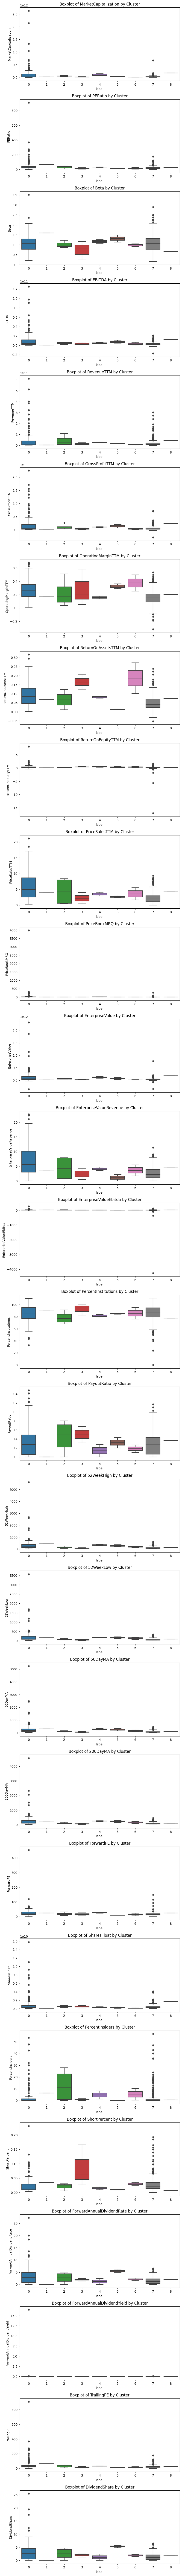

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame containing the features and the 'label' column

# List of features to plot
features = ['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'RevenueTTM',
    'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'PriceSalesTTM',
    'PriceBookMRQ', 'EnterpriseValue', 'EnterpriseValueRevenue',
    'EnterpriseValueEbitda', 'PercentInstitutions','PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA',
    'ForwardPE', 'SharesFloat', 'PercentInsiders', 'ShortPercent',
    'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 'TrailingPE',
    'DividendShare',]  # Add more features if needed

# Create subplots for each feature
fig, axes = plt.subplots(len(features), 1, figsize=(8, 4 * len(features)))

# Iterate over each feature and create a boxplot
for i, feature in enumerate(features):
    sns.boxplot(x='label', y=feature, data=unscaled_results_df, ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature} by Cluster")

plt.tight_layout()
plt.show()